In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

folder = '../runs/dev/train'
plot_folder = '../plots/dev'

make_dir(plot_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# metrics_df = pd.read_parquet(os.path.join(folder, 'metrics.parquet'))
# confusion_matrix_df = pd.read_parquet(os.path.join(folder, 'confusion_matrix.parquet'))

metrics_df = merge_files_by_name(folder, 'metrics.parquet')
confusion_matrix_df = merge_files_by_name(folder, 'confusion_matrix.parquet')
synthethetic_df = merge_files_by_name(folder, 'synthetic_predicitions.parquet')

In [12]:
metrics_df.columns

Index(['cont_ordinal', 'int_ordinal', 'pun_ordinal', 'y_ordinal', 'name',
       'value', 'set', 'cv_split'],
      dtype='object')

In [27]:
metrics_df.name.unique()

array(['mean_absolute_error', 'accuracy', 'log_loss'], dtype=object)

In [21]:
labels = ['cont_ordinal', 'int_ordinal', 'pun_ordinal', 'y_ordinal']
metrics_df['label'] = ''
bw = ''
for l in labels:
    metrics_df['label'] += (bw + l + ':') + metrics_df[l].astype(str)
    bw = ' '

<AxesSubplot:xlabel='value', ylabel='label'>

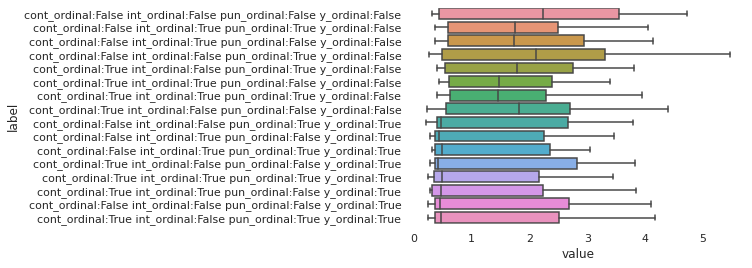

In [29]:
w = (
    # (metrics_df['name'] == 'accuracy') &
    (metrics_df['set'] == 'test')
)
df = metrics_df[w]
df = df.sort_values('y_ordinal')
sns.boxplot(data=df, x='value', y='label', orient='h')

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


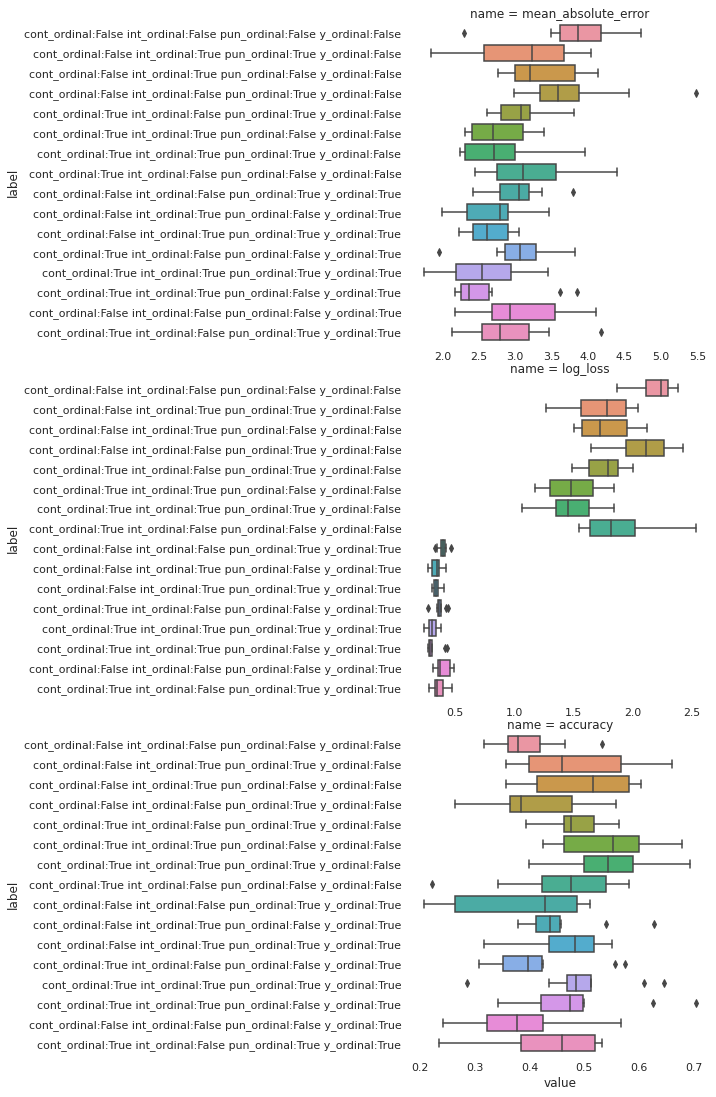

In [37]:
sns.catplot(data=df, x='value', row='name', y='label', orient='h', kind='box', sharex=False)

In [ ]:
# y_ordinal = [True, False]
# cont_ordinal = True
# pun_ordinal = False
# int_ordinal = True

<AxesSubplot:xlabel='y_pred', ylabel='y_true'>

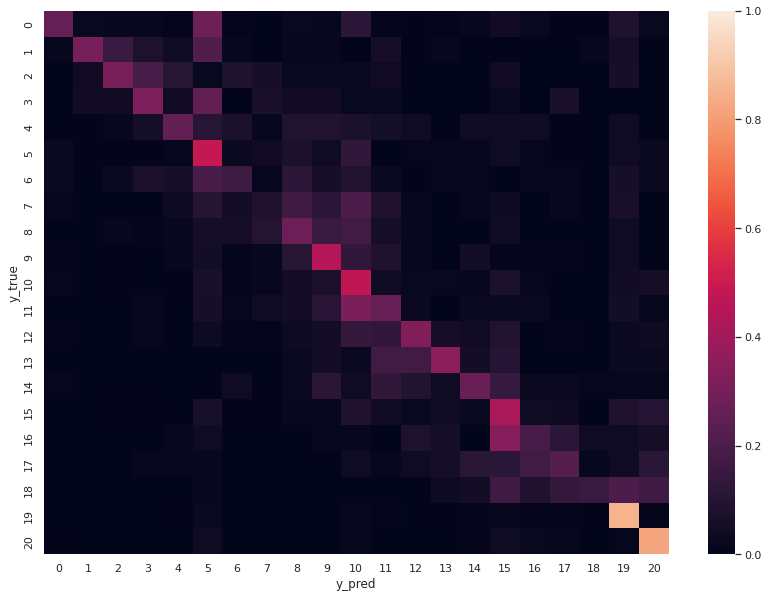

In [40]:
# Todo: double check the normalisation
w = (
    (confusion_matrix_df['cont_ordinal']) &
    (confusion_matrix_df['pun_ordinal']) &
    (confusion_matrix_df['int_ordinal']) &
    (confusion_matrix_df['y_ordinal'])
)

cm_g_df = confusion_matrix_df[w].groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
cm_g_df['fraction'] = cm_g_df['value'] / cm_g_df.groupby(['set', 'y_true'])['value'].transform('sum')
cm = cm_g_df.pivot_table(index=['set', 'y_true'], columns='y_pred', values='fraction')

plt.figure(figsize=(14,10))
sns.heatmap(cm.loc['test'], vmin=0, vmax=1)
# plt.savefig(os.path.join(plot_folder, 'confusion_matrix.jpg'), dpi=300, transparent=False)

<AxesSubplot:xlabel='y_pred', ylabel='y_true'>

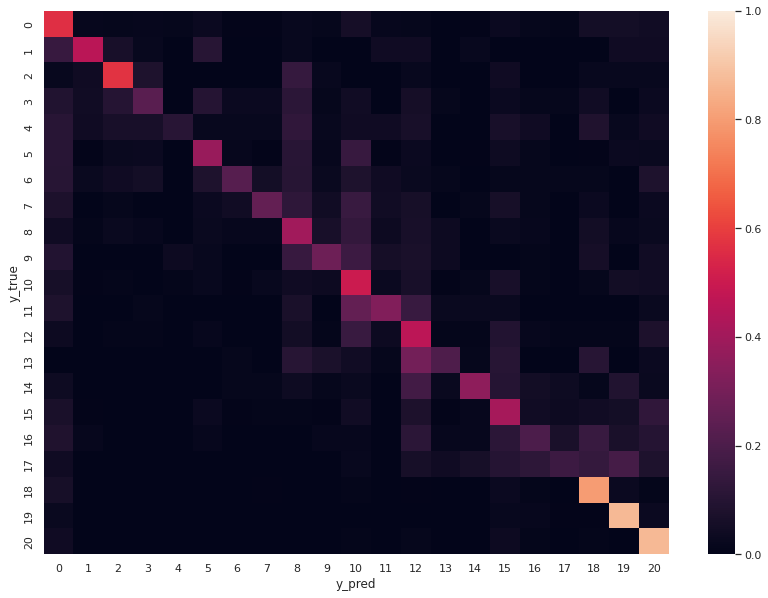

In [41]:
# Todo: double check the normalisation
w = (
    (confusion_matrix_df['cont_ordinal']) &
    (confusion_matrix_df['pun_ordinal']) &
    (confusion_matrix_df['int_ordinal']) &
    (~confusion_matrix_df['y_ordinal'])
)

cm_g_df = confusion_matrix_df[w].groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
cm_g_df['fraction'] = cm_g_df['value'] / cm_g_df.groupby(['set', 'y_true'])['value'].transform('sum')
cm = cm_g_df.pivot_table(index=['set', 'y_true'], columns='y_pred', values='fraction')

plt.figure(figsize=(14,10))
sns.heatmap(cm.loc['test'], vmin=0, vmax=1)

In [42]:
# Todo: double check the normalisation
w = (
    (synthethetic_df['cont_ordinal']) &
    (synthethetic_df['pun_ordinal']) &
    (synthethetic_df['int_ordinal']) &
    (synthethetic_df['y_ordinal'])
)

df = synthethetic_df[w]
# df = synthethetic_df[w].groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
# df['fraction'] = df['value'] / df.groupby(['set', 'y_true'])['value'].transform('sum')
# cm = df.pivot_table(index=['set', 'y_true'], columns='y_pred', values='fraction')

# plt.figure(figsize=(14,10))
# sns.heatmap(cm.loc['test'], vmin=0, vmax=1)

In [45]:
df.columns

Index(['cont_ordinal', 'int_ordinal', 'pun_ordinal', 'y_ordinal', 'set',
       'cv_split', 'prev_contribution', 'round', 'prev_punishment',
       'sample_idx', 'contribution', 'proba', 'predicted', 'exp_contribution'],
      dtype='object')

In [53]:
df['exp_contribution'] = df['contribution'] * df['proba']

dfg = df.groupby(['cont_ordinal', 'int_ordinal', 'pun_ordinal', 'y_ordinal', 'set', 'cv_split', 'prev_contribution', 'round', 'prev_punishment',
       'sample_idx'])['exp_contribution'].sum()
dfg = dfg.reset_index()

/tmp/ipykernel_6785/991096598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['exp_contribution'] = df['contribution'] * df['proba']


In [51]:
# Todo: double check the normalisation
w = (
    (dfg['cont_ordinal']) &
    (dfg['pun_ordinal']) &
    (dfg['int_ordinal']) &
    (~dfg['y_ordinal'])
)

# df = dfg[w].groupby(['set', 'y_true', 'y_pred'])['value'].sum().reset_index()
# df['fraction'] = df['value'] / cm_g_df.groupby(['set', 'y_true'])['value'].transform('sum')
cm = df.pivot_table(index=['set', 'prev_contribution'], columns='prev_punishment', values='exp_contribution')

plt.figure(figsize=(14,10))
sns.heatmap(cm.loc['test'], vmin=0, vmax=1)

cont_ordinal  int_ordinal  pun_ordinal  y_ordinal    set  cv_split  \
0               True         True         True       True  train         0   
1               True         True         True       True  train         0   
2               True         True         True       True  train         0   
3               True         True         True       True  train         0   
4               True         True         True       True  train         0   
...              ...          ...          ...        ...    ...       ...   
136705          True         True         True       True  train         9   
136706          True         True         True       True  train         9   
136707          True         True         True       True  train         9   
136708          True         True         True       True  train         9   
136709          True         True         True       True  train         9   

        prev_contribution  round  prev_punishment  sample_idx  contribution  \
0                       0      1                0           0             0   
1                       0      1                0           0             1   
2                       0      1                0           0             2   
3                       0      1                0           0             3   
4                       0      1                0           0             4   
...                   ...    ...              ...         ...           ...   
136705                 20      1               30         650            16   
136706                 20      1               30         650            17   
136707                 20      1               30         650            18   
136708                 20      1               30         650            19   
136709                 20      1               30         650            20   

        exp_contribution  
0               0.000000  
1               0.656195  
2               1.228837  
3               1.818843  
4               2.391013  
...                  ...  
136705          8.845531  
136706          9.012632  
136707          9.366909  
136708          5.392321  
136709          4.380859  

[136710 rows x 12 columns]